## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# get the number of rows in the dataset
num_rows = df.shape[0]
num_rows

294478

c. The number of unique users in the dataset.

In [4]:
# get the number of unique users in the dataset
num_unique_users = df['user_id'].nunique()
num_unique_users

290584

d. The proportion of users converted.

In [5]:
# get the number of converted users
num_converted_users = df.query('converted == 1').user_id.nunique()

# calculate the proportion of converted users
prop_converted_users = num_converted_users/num_unique_users
num_converted_users, prop_converted_users

(35173, 0.12104245244060237)

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# calculate the number of 'treatment' rows that are not 'new_page'
treat_df = df.query('group == "treatment"')
treat_not_new = treat_df.query('landing_page != "new_page"').shape[0]

# calculate the number of 'new_page' rows that are not 'treatment'
land_new_df = df.query('landing_page == "new_page"')
new_not_treat = land_new_df.query('group != "treatment"').shape[0]

# calculate the total number of rows that do not match 'new_page' and 'treatment'
num_no_match_new_treatment = treat_not_new + new_not_treat
num_no_match_new_treatment

3893

In [7]:
# check which unique values are there in 'group' column
df['group'].unique()

array(['control', 'treatment'], dtype=object)

In [8]:
# check which unique values are there in 'landing_page' column
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

f. Do any of the rows have missing values?

In [9]:
# get summary information concerning the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**In this dataset, there are no rows with missing data. All columns have non-null values for all rows.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# create a new dataset df2 with only the rows where 'treatment' matches 'new_page' and
# 'control' matches 'old_page'
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')
df2.shape[0]

290585

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
# get the number of unique users
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# get the number of duplicated user_ids
df2['user_id'].duplicated().sum()

1

In [14]:
# get the user_id of the duplicated user
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

**The duplicated user has the user_id 773192.**

c. What is the row information for the repeat **user_id**? 

In [15]:
# get the row information for the duplicated user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
# remove one of the rows with the duplicated user_id from df2
df2.drop_duplicates(subset=['user_id'], keep='first',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# check if the duplicated user_id was removed
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
# calculate the probability of an individual converting regardless of the landing_page
df2['converted'].mean()

0.11959708724499628

**The probability of an individual converting regardless of the landing_page is 11.96%.**

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
# calculate the probability of an individual converting, given it is in control group
(df2.query('group == "control"')['converted'] == 1).mean()

0.1203863045004612

**The probability of an individual converting, given it is in the control group, is 12.04%.**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
# calculate the probability of an individual converting, given it is in treatment group
(df2.query('group == "treatment"')['converted'] == 1).mean()

0.11880806551510564

**The probability of an individual converting, given it is in the treatment group, is 11.88%.**

d. What is the probability that an individual received the new page?

In [21]:
# calculate the probability of an individual to receive the new_page
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**The probability of an individual to receive the new_page is 50%.**

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Let's analyse the above values:** <br>
**1. The probability that an individual receives the new page is 50%, which means that half of the individuals receive the new page and the other half receive the old page.** <br>
**2. The probabilities of converting are:**
- Probability of an individual regardless of the group: 11.96%
- Probability of an individual from control group: 12.04%
- Probability of an individual from treatment group: 11.88%

**These 3 values are aproximately equivalent (12%), which means that there is no change in the conversions in the new page (treatment group) when compared with the old page (control group).** <br><br>
**Considering the above values, we can conclude that there is no sufficient evidence that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The null and alternative hypotheses are:** <br>
**H<sub>0</sub>: p<sub>new</sub>  $\leqslant$ p<sub>old</sub> or p<sub>new</sub> - p<sub>old</sub> $\leqslant$ 0**<br>
**H<sub>1</sub>: p<sub>new</sub> $\gt$  p<sub>old</sub> or p<sub>new</sub> - p<sub>old</sub> $\gt$ 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
# calculate the conversion rate for the new_page, assuming that 
# it is equal to the conversion rate in 'ab_data.csv' regardless 
# of the landing page
p_newpage = df2['converted'].mean()
p_newpage

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
# calculate the conversion rate for the old_page, assuming that 
# it is equal to the conversion rate in 'ab_data.csv' regardless
# of the landing page
p_oldpage = df2['converted'].mean()
p_oldpage

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
# calculate the number of users in the treatment group 
# (landing_page: new_page)
n_new = df2[df2['landing_page']=='new_page'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
# calculate the number of users in the control group 
# (landing_page: old_page)
n_old = df2[df2['landing_page']=='old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
# simulate n_new transactions with a conversion rate of p_newpage 
# under the null
new_page_converted = np.random.choice([0,1], n_new, p=(p_newpage, 1-p_newpage))
new_page_converted

array([1, 1, 1, ..., 1, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
# simulate n_old transactions with a conversion rate of p_oldpage 
# under the null
old_page_converted = np.random.choice([0,1], n_old, p=(p_oldpage, 1-p_oldpage))
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# find the difference between the probabilities of the new and old 
# pages of the simulated values
new_page_converted.mean() - old_page_converted.mean()

0.0024865274506462587

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
# simulate 10000 conversion rates differences
# using sampling distribution with bootstrapping
p_diffs = []

for _ in range(10000):
    boot_samp = df2.sample(df2.shape[0], replace=True)
    
    # get a separate dataset for each group: control and treatment
    df_old = boot_samp.query('group == "control"')
    df_new = boot_samp.query('group == "treatment"')
    
    # probabilities of conversion of each group
    p_old = df_old['converted'].mean()
    p_new = df_new['converted'].mean()
    
    # use as sample size the number of converted users in each group (1's)
    n_old = df_old['converted'].shape[0]
    n_new = df_new['converted'].shape[0]
    
    # simulate the values
    old_conv = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    new_conv = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    
    # store the conversion rates differences in p_diffs
    p_diffs.append(new_conv.mean() - old_conv.mean())
    
# convert to a numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

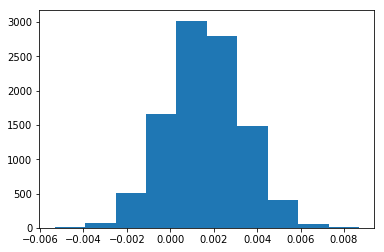

In [30]:
# plot the histogram
plt.hist(p_diffs);

**The plot of the histogram is as expected: the histogram is symmetric and it is shaped as a bell curve which means that the data has a normal distribution.**

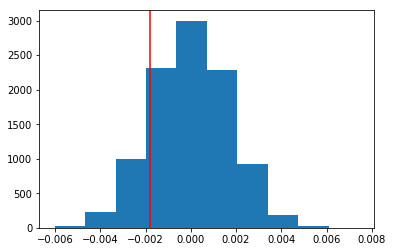

In [31]:
# using this sampling distribution, simulate from the null by
# creating a random normal distribution centered at 0 with the
# same spread and size
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# calculate the observed conversion rates for each page (new and old)
n_converted_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_converted_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
rate_new = n_converted_new/n_new
rate_old = n_converted_old/n_old

# calculate the observed difference in the conversion rates
obs_diff = rate_new - rate_old

# plot the histogram and the line of the observed difference in the conversion rates
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# calculate the proportion of the p_diffs that are greater than the observed difference
# (P-value)
p_value = (null_vals > obs_diff).mean()
p_value

0.84609999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The proportion of the p_diffs that are greater than the actual difference is called the P-value. It is the probability of observing our statistic, or one more extreme in favor of the alternative, if the null is true.**<br>
**The P-value is 0.8461 and the Type I error rate ($\alpha$) is 0.05   (5%).**<br><br>
**Based on the data, we fail to reject the null hypothesis because P-value $\gt$ $\alpha$.**<br>
**Which means that the difference between the conversion rates of the new and the old pages is less or equal to zero (H<sub>0</sub>). In other words, with a type I error of 0.05, the new page doesn't lead to more conversions than the old page and there is no difference between the conversion rates of the new and the old pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

# get the number of conversions for each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]

# get the total number of individuals who received each page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
# compute the test statistic and P-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

In [35]:
import scipy.stats as st

# the cumulative distribution function indicates if z_score is significant
st.norm.cdf(z_score)

0.094941687240975514

In [36]:
# calculate the critical value with a confidence interval of 95%
# using percent point function
st.norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**We fail to reject the null hypothesis because we have a P-value of 0.9051, greater than Type I error rate (0.05), and the z-score (1.3109) is bellow the critical value (1.95996).**<br>
**Therefore, the difference between the conversion rates of the new and the old pages is lower or equal to zero (null hypothesis). In other words, there is no difference between conversion rates of the new and old pages, which is the same conclusion we reached in the parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should perform the Logistic Regression because it predicts a categorical response and it is used to predict one of two possible outcomes, like in this case: conversion or no conversion.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# create the dummy variable for the landing page (categorical variable)
df2[['new_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
# drop old_page column
df2 = df2.drop('old_page', axis=1)

# create an ab_page column (1 if treatment, 0 if control)
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

# create the intercept column in df2
df2['intercept'] = 1

df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
# create the logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
# get the summary results of the model
# note: using the 'summary' function, there was an internal error: the module 
# 'scipy.stats' has no attribute 'chisqprob'.
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-24 20:37 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The P-value associated with ab_page is 0.1899. In part II (A-B Test), the P-value was 0.8460. These values are different because in the case of Sampling Distribution (part II), the P-value refers to the probability of observing our statistic, or one more extreme in favor of the alternative, if the null is true, and in the case of the logistic regression (part III), the P-value associated with ab_page indicates if it is statistically significant in predicting the response variable (converted: 0 or 1).**<br><br>
**The null and alternative hypothesis associated with the regression model are:**<br>
**H<sub>0</sub>: no difference between conversion rates of treatment and control groups**<br>
**H<sub>1</sub>: treatment and control groups conversion rates are different**<br><br>
**The null and alternative hypothesis in part II are:**<br>
**H<sub>0</sub>: new page conversion rate is lower or equal to the old page conversion rate**<br>
**H<sub>1</sub>: new page conversion rate is greater than the old page conversion rate**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to add other factors into our regression model in order to get a more complete analysis and understand other variables that might influence the conversion rate. Another variable that we could add to this regression model is timestamp. It would be usefull to analyse how it influences the conversion rate and we could extract different informations from the timestamp, for example: the time period of the day, if it is a weekday or weekend and the month of the year.**<br>
**The disadvantage of adding additional terms into the regression model is the increase of complexity of the results interpretation.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [40]:
# read country data from 'countries.csv' file
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [41]:
# merge df2 and country_df datasets
new_df = df2.merge(country_df, on='user_id', how='left')
new_df.head()

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,US


In [42]:
# check which countries are there in the dataset
new_df['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [43]:
# create the dummy variables
new_df[['CA', 'UK', 'US']] = pd.get_dummies(new_df['country'])

# drop CA column
new_df = new_df.drop('CA', axis=1)
new_df.head()

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,US,0,1


In [44]:
# create the logistic regression model
logit_mod2 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'US']])

# fit the model
results2 = logit_mod2.fit()

# get results summary
# note: using the 'summary' function, there was an internal error: the module
# 'scipy.stats' has no attribute 'chisqprob'
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-24 20:39 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**From this summary, we can interpret as follows:**<br>
**1. The P-values of the variables (except the intercept) have not low values (greater than 0.05) and that suggests that there are no variables statistically significant for the conversion rate.**<br>
**2. A change in the variable ab_page decreases the odds of the conversion by 0.015, holding all other variables constant.**<br>
**3. A change in UK users increases the odds of the conversion by 0.05, holding all other variables constant.**<br>
**4. A change in US users increases the odds of conversion by 0.04, holding all other variables constant.**

In [45]:
# calculate the coefficients exponential values
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [46]:
# calculate the inverse of the coefficient exponential of 
# ab_page (because the coefficient has a negative value)
ad_page_exp_coef = 1/0.985168
ad_page_exp_coef

1.0150553002127556

**From these coefficient exponential values, we can get the odds ratio for a level compared to the baseline, as follows:**<br>
**1. For the ab_page, as compared to the baseline, we expect a multiplicative change in the odds of converting by 1.015, holding all other variables constant.**<br>
**2. For the UK users, as compared to the baseline, we expect a multiplicative change in the odds of converting by 1.052, holding all other variables constant.**<br>
**3. For the US users, as compared to the baseline, we expect a multiplicative change in the odds of converting by 1.042, holding all other variables constant.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
# create the new variables for interaction between page and country
new_df['newpage_UK'] = new_df['UK'] * new_df['new_page']
new_df['newpage_US'] = new_df['US'] * new_df['new_page']
new_df.head()

,user_id,timestamp,group,landing_page,converted,new_page,ab_page,intercept,country,UK,US,newpage_UK,newpage_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,0,1,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,0,1,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,0,1,US,0,1,0,0


In [49]:
# create the logistic regression model
logit_mod3 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'US', 'newpage_UK', 'newpage_US']])

# fit the model
results3 = logit_mod3.fit()

# get results summary
# note: using the 'summary' function, there was an internal error: the module
# 'scipy.stats' has no attribute 'chisqprob'
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-03-24 20:41 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
newpage_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
newpage_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

**From this summary, we can interpret the following:**<br>
**1. The P-values for all the variables (except the intercept) are not low values (greater than 0.05), which suggests that these variables are not statistically significant for the conversion rate.**<br>

In [50]:
# exponentiate each of the coefficients in results3
np.exp(results3.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
US            1.017682
newpage_UK    1.081428
newpage_US    1.048001
dtype: float64

**The exponentiated coefficients for these categorical variables can give us the odds ratio as follows:**<br>
**1. For the new pages in UK (newpage_UK), as compared to the baseline, we expect a multiplicative change in the odds of converting (being 1) by 1.0814, holding all other variables constant.**<br>
**2. For the new pages in US (newpage_US), as compared to the baseline, we expect a multiplicative change in the odds of converting (being 1) by 1.0480,holding all other variables constant.**

<a id='conclusions'></a>
## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0